<a href="https://colab.research.google.com/github/BogdanGFTP/tiny-yolo/blob/master/Tiny_YOLO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from shutil import unpack_archive
unpack_archive('gdrive/My Drive/coco_ds/train_ann.zip')

In [0]:
unpack_archive('gdrive/My Drive/coco_ds/val_ann.zip')

In [0]:
from keras.models import Sequential, Model
from keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.optimizers import SGD, Adam
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import random
import os

%matplotlib inline

import xml.etree.ElementTree as ET
import tensorflow as tf
import copy
import cv2

**UTILS**

In [4]:
class WeightReader:
    def __init__(self, weight_file):
        self.offset = 4
        self.all_weights = np.fromfile(weight_file, dtype='float32')
        
    def read_bytes(self, size):
        self.offset = self.offset + size
        return self.all_weights[self.offset-size:self.offset]
    
    def reset(self):
        self.offset = 4
        
        
from keras.utils import Sequence

def decode_netout(netout, anchors, nb_class, obj_threshold=0.3, nms_threshold=0.3):
    grid_h, grid_w, nb_box = netout.shape[:3]

    boxes = []
    
    # decode the output by the network
    netout[..., 4]  = _sigmoid(netout[..., 4])
    netout[..., 5:] = netout[..., 4][..., np.newaxis] * _softmax(netout[..., 5:])
    netout[..., 5:] *= netout[..., 5:] > obj_threshold
    
    for row in range(grid_h):
        for col in range(grid_w):
            for b in range(nb_box):
                # from 4th element onwards are confidence and class classes
                classes = netout[row,col,b,5:]
                
                if np.sum(classes) > 0:
                    # first 4 elements are x, y, w, and h
                    x, y, w, h = netout[row,col,b,:4]

                    x = (col + _sigmoid(x)) / grid_w # center position, unit: image width
                    y = (row + _sigmoid(y)) / grid_h # center position, unit: image height
                    w = anchors[2 * b + 0] * np.exp(w) / grid_w # unit: image width
                    h = anchors[2 * b + 1] * np.exp(h) / grid_h # unit: image height
                    confidence = netout[row,col,b,4]
                    
                    box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, confidence, classes)
                    
                    boxes.append(box)

    # suppress non-maximal boxes
    for c in range(nb_class):
        sorted_indices = list(reversed(np.argsort([box.classes[c] for box in boxes])))

        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]
            
            if boxes[index_i].classes[c] == 0: 
                continue
            else:
                for j in range(i+1, len(sorted_indices)):
                    index_j = sorted_indices[j]
                    
                    if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_threshold:
                        boxes[index_j].classes[c] = 0
                        
    # remove the boxes which are less likely than a obj_threshold
    boxes = [box for box in boxes if box.get_score() > obj_threshold]
    
    return boxes    

def draw_boxes(image, boxes, labels):
    image_h, image_w, _ = image.shape

    for box in boxes:
        xmin = int(box.xmin*image_w)
        ymin = int(box.ymin*image_h)
        xmax = int(box.xmax*image_w)
        ymax = int(box.ymax*image_h)

        cv2.rectangle(image, (xmin,ymin), (xmax,ymax), (0,255,0), 3)
        cv2.putText(image, 
                    labels[box.get_label()] + ' ' + str(box.get_score()), 
                    (xmin, ymin - 13), 
                    cv2.FONT_HERSHEY_SIMPLEX, 
                    1e-3 * image_h, 
                    (0,255,0), 2)
        
    return image  
  
class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, c = None, classes = None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        
        self.c     = c
        self.classes = classes

        self.label = -1
        self.score = -1

    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)
        
        return self.label
    
    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]
            
        return self.score


def bbox_iou(box1, box2):
    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])  
    
    intersect = intersect_w * intersect_h

    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
    
    union = w1*h1 + w2*h2 - intersect
    
    return float(intersect) / union


def parse_annotation(ann_dir, img_dir, labels=[]):
    all_imgs = []
    seen_labels = {}
    
    for ann in sorted(os.listdir(ann_dir)):
        img = {'object':[]}

        tree = ET.parse(ann_dir + ann)
        
        for elem in tree.iter():
            if 'filename' in elem.tag:
                img['filename'] = img_dir + elem.text
            if 'width' in elem.tag:
                img['width'] = int(elem.text)
            if 'height' in elem.tag:
                img['height'] = int(elem.text)
            if 'object' in elem.tag or 'part' in elem.tag:
                obj = {}
                
                for attr in list(elem):
                    if 'name' in attr.tag:
                        obj['name'] = attr.text

                        if obj['name'] in seen_labels:
                            seen_labels[obj['name']] += 1
                        else:
                            seen_labels[obj['name']] = 1
                        
                        if len(labels) > 0 and obj['name'] not in labels:
                            break
                        else:
                            img['object'] += [obj]
                            
                    if 'bndbox' in attr.tag:
                        for dim in list(attr):
                            if 'xmin' in dim.tag:
                                obj['xmin'] = int(round(float(dim.text)))
                            if 'ymin' in dim.tag:
                                obj['ymin'] = int(round(float(dim.text)))
                            if 'xmax' in dim.tag:
                                obj['xmax'] = int(round(float(dim.text)))
                            if 'ymax' in dim.tag:
                                obj['ymax'] = int(round(float(dim.text)))

        if len(img['object']) > 0:
            all_imgs += [img]
                        
    return all_imgs, seen_labels
  
  
class BatchGenerator(Sequence):
    def __init__(self, images, 
                       config, 
                       shuffle=True, 
                       jitter=True, 
                       norm=None):
        self.generator = None

        self.images = images
        self.config = config

        self.shuffle = shuffle
        self.jitter  = jitter
        self.norm    = norm

        self.anchors = [BoundBox(0, 0, config['ANCHORS'][2*i], config['ANCHORS'][2*i+1]) for i in range(int(len(config['ANCHORS'])//2))]

        ### augmentors by https://github.com/aleju/imgaug
        sometimes = lambda aug: iaa.Sometimes(0.5, aug)

        # Define our sequence of augmentation steps that will be applied to every image
        # All augmenters with per_channel=0.5 will sample one value _per image_
        # in 50% of all cases. In all other cases they will sample new values
        # _per channel_.
        self.aug_pipe = iaa.Sequential(
            [
                # apply the following augmenters to most images
                #iaa.Fliplr(0.5), # horizontally flip 50% of all images
                #iaa.Flipud(0.2), # vertically flip 20% of all images
                #sometimes(iaa.Crop(percent=(0, 0.1))), # crop images by 0-10% of their height/width
                sometimes(iaa.Affine(
                    #scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
                    #translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
                    #rotate=(-5, 5), # rotate by -45 to +45 degrees
                    #shear=(-5, 5), # shear by -16 to +16 degrees
                    #order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
                    #cval=(0, 255), # if mode is constant, use a cval between 0 and 255
                    #mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
                )),
                # execute 0 to 5 of the following (less important) augmenters per image
                # don't execute all of them, as that would often be way too strong
                iaa.SomeOf((0, 5),
                    [
                        #sometimes(iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))), # convert images into their superpixel representation
                        iaa.OneOf([
                            iaa.GaussianBlur((0, 3.0)), # blur images with a sigma between 0 and 3.0
                            iaa.AverageBlur(k=(2, 7)), # blur image using local means with kernel sizes between 2 and 7
                            iaa.MedianBlur(k=(3, 11)), # blur image using local medians with kernel sizes between 2 and 7
                        ]),
                        iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)), # sharpen images
                        #iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # emboss images
                        # search either for all edges or for directed edges
                        #sometimes(iaa.OneOf([
                        #    iaa.EdgeDetect(alpha=(0, 0.7)),
                        #    iaa.DirectedEdgeDetect(alpha=(0, 0.7), direction=(0.0, 1.0)),
                        #])),
                        iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5), # add gaussian noise to images
                        iaa.OneOf([
                            iaa.Dropout((0.01, 0.1), per_channel=0.5), # randomly remove up to 10% of the pixels
                            #iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2),
                        ]),
                        #iaa.Invert(0.05, per_channel=True), # invert color channels
                        iaa.Add((-10, 10), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
                        iaa.Multiply((0.5, 1.5), per_channel=0.5), # change brightness of images (50-150% of original value)
                        iaa.ContrastNormalization((0.5, 2.0), per_channel=0.5), # improve or worsen the contrast
                        #iaa.Grayscale(alpha=(0.0, 1.0)),
                        #sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)), # move pixels locally around (with random strengths)
                        #sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))) # sometimes move parts of the image around
                    ],
                    random_order=True
                )
            ],
            random_order=True
        )

        if shuffle: np.random.shuffle(self.images)

    def __len__(self):
        return int(np.ceil(float(len(self.images))/self.config['BATCH_SIZE']))   

    def num_classes(self):
        return len(self.config['LABELS'])

    def size(self):
        return len(self.images)    

    def load_annotation(self, i):
        annots = []

        for obj in self.images[i]['object']:
            annot = [obj['xmin'], obj['ymin'], obj['xmax'], obj['ymax'], self.config['LABELS'].index(obj['name'])]
            annots += [annot]

        if len(annots) == 0: annots = [[]]

        return np.array(annots)

    def load_image(self, i):
        return cv2.imread(self.images[i]['filename'])

    def __getitem__(self, idx):
        l_bound = idx*self.config['BATCH_SIZE']
        r_bound = (idx+1)*self.config['BATCH_SIZE']

        if r_bound > len(self.images):
            r_bound = len(self.images)
            l_bound = r_bound - self.config['BATCH_SIZE']

        instance_count = 0

        x_batch = np.zeros((r_bound - l_bound, self.config['IMAGE_H'], self.config['IMAGE_W'], 3))                         # input images
        b_batch = np.zeros((r_bound - l_bound, 1     , 1     , 1    ,  self.config['TRUE_BOX_BUFFER'], 4))   # list of self.config['TRUE_self.config['BOX']_BUFFER'] GT boxes
        y_batch = np.zeros((r_bound - l_bound, self.config['GRID_H'],  self.config['GRID_W'], self.config['BOX'], 4+1+len(self.config['LABELS'])))                # desired network output

        for train_instance in self.images[l_bound:r_bound]:
            # augment input image and fix object's position and size
            img, all_objs = self.aug_image(train_instance, jitter=self.jitter)
            
            # construct output from object's x, y, w, h
            true_box_index = 0
            
            for obj in all_objs:
                if obj['xmax'] > obj['xmin'] and obj['ymax'] > obj['ymin'] and obj['name'] in self.config['LABELS']:
                    center_x = .5*(obj['xmin'] + obj['xmax'])
                    center_x = center_x / (float(self.config['IMAGE_W']) / self.config['GRID_W'])
                    center_y = .5*(obj['ymin'] + obj['ymax'])
                    center_y = center_y / (float(self.config['IMAGE_H']) / self.config['GRID_H'])

                    grid_x = int(np.floor(center_x))
                    grid_y = int(np.floor(center_y))

                    if grid_x < self.config['GRID_W'] and grid_y < self.config['GRID_H']:
                        obj_indx  = self.config['LABELS'].index(obj['name'])
                        
                        center_w = (obj['xmax'] - obj['xmin']) / (float(self.config['IMAGE_W']) / self.config['GRID_W']) # unit: grid cell
                        center_h = (obj['ymax'] - obj['ymin']) / (float(self.config['IMAGE_H']) / self.config['GRID_H']) # unit: grid cell
                        
                        box = [center_x, center_y, center_w, center_h]

                        # find the anchor that best predicts this box
                        best_anchor = -1
                        max_iou     = -1
                        
                        shifted_box = BoundBox(0, 
                                               0,
                                               center_w,                                                
                                               center_h)
                        
                        for i in range(len(self.anchors)):
                            anchor = self.anchors[i]
                            iou    = bbox_iou(shifted_box, anchor)
                            
                            if max_iou < iou:
                                best_anchor = i
                                max_iou     = iou
                                
                        # assign ground truth x, y, w, h, confidence and class probs to y_batch
                        y_batch[instance_count, grid_y, grid_x, best_anchor, 0:4] = box
                        y_batch[instance_count, grid_y, grid_x, best_anchor, 4  ] = 1.
                        y_batch[instance_count, grid_y, grid_x, best_anchor, 5+obj_indx] = 1
                        
                        # assign the true box to b_batch
                        b_batch[instance_count, 0, 0, 0, true_box_index] = box
                        
                        true_box_index += 1
                        true_box_index = true_box_index % self.config['TRUE_BOX_BUFFER']
                            
            # assign input image to x_batch
            if self.norm != None: 
                x_batch[instance_count] = self.norm(img)
            else:
                # plot image and bounding boxes for sanity check
                for obj in all_objs:
                    if obj['xmax'] > obj['xmin'] and obj['ymax'] > obj['ymin']:
                        cv2.rectangle(img[:,:,::-1], (obj['xmin'],obj['ymin']), (obj['xmax'],obj['ymax']), (255,0,0), 3)
                        cv2.putText(img[:,:,::-1], obj['name'], 
                                    (obj['xmin']+2, obj['ymin']+12), 
                                    0, 1.2e-3 * img.shape[0], 
                                    (0,255,0), 2)
                        
                x_batch[instance_count] = img

            # increase instance counter in current batch
            instance_count += 1  

        #print(' new batch created', idx)

        return [x_batch, b_batch], y_batch

    def on_epoch_end(self):
        if self.shuffle: np.random.shuffle(self.images)

    def aug_image(self, train_instance, jitter):
        image_name = train_instance['filename']
        image = cv2.imread(image_name)

        if image is None: print('Cannot find ', image_name)

        h, w, c = image.shape
        all_objs = copy.deepcopy(train_instance['object'])

        if jitter:
            ### scale the image
            scale = np.random.uniform() / 10. + 1.
            image = cv2.resize(image, (0,0), fx = scale, fy = scale)

            ### translate the image
            max_offx = (scale-1.) * w
            max_offy = (scale-1.) * h
            offx = int(np.random.uniform() * max_offx)
            offy = int(np.random.uniform() * max_offy)
            
            image = image[offy : (offy + h), offx : (offx + w)]

            ### flip the image
            flip = np.random.binomial(1, .5)
            if flip > 0.5: image = cv2.flip(image, 1)
                
            image = self.aug_pipe.augment_image(image)            
            
        # resize the image to standard size
        image = cv2.resize(image, (self.config['IMAGE_H'], self.config['IMAGE_W']))
        image = image[:,:,::-1]

        # fix object's position and size
        for obj in all_objs:
            for attr in ['xmin', 'xmax']:
                if jitter: obj[attr] = int(obj[attr] * scale - offx)
                    
                obj[attr] = int(obj[attr] * float(self.config['IMAGE_W']) / w)
                obj[attr] = max(min(obj[attr], self.config['IMAGE_W']), 0)
                
            for attr in ['ymin', 'ymax']:
                if jitter: obj[attr] = int(obj[attr] * scale - offy)
                    
                obj[attr] = int(obj[attr] * float(self.config['IMAGE_H']) / h)
                obj[attr] = max(min(obj[attr], self.config['IMAGE_H']), 0)

            if jitter and flip > 0.5:
                xmin = obj['xmin']
                obj['xmin'] = self.config['IMAGE_W'] - obj['xmax']
                obj['xmax'] = self.config['IMAGE_W'] - xmin
                
        return image, all_objs
      
      
      
def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b

    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
             return 0
        else:
            return min(x2,x4) - x3  
          
          


Using TensorFlow backend.


In [0]:
wt_path = 'gdrive/My Drive/coco_ds/yolov2-tiny.weights'                      
train_image_folder = 'gdrive/My Drive/coco_ds/train2014/'
train_annot_folder = 'train_annot/'
valid_image_folder = 'gdrive/My Drive/coco_ds/val2014/'
valid_annot_folder = 'val_annot/'

In [0]:
LABELS = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

IMAGE_H, IMAGE_W = 416, 416
GRID_H,  GRID_W  = 13 , 13
BOXES            = 5
CLASSES          = len(LABELS)
CLASS_WEIGHTS    = np.ones(CLASSES, dtype='float32')
OBJ_THRESHOLD    = 0.2#0.5
NMS_THRESHOLD    = 0.2#0.45
ANCHORS          = '1.08,1.19,  3.42,4.41,  6.63,11.38,  9.42,5.11,  16.62,10.52'
ANCHORS          = [float(ANCHORS.strip()) for ANCHORS in ANCHORS.split(',')]

SCALE_NOOB, SCALE_CONF, SCALE_COOR, SCALE_PROB = 0.5, 5.0, 5.0, 1.0
weight_reader = WeightReader(wt_path)

BATCH_SIZE       = 8
WARM_UP_BATCHES  = 0
TRUE_BOX_BUFFER  = 50

In [8]:
import gc; gc.enable()
gc.collect()

4

In [21]:
gc.collect()

0

In [0]:
from keras import backend as K
K.clear_session()

In [9]:
# MODEL

# input_size = (IMAGE_H, IMAGE_W, 3)

# inputs = Input(input_size)
true_boxes  = Input(shape=(1, 1, 1, TRUE_BOX_BUFFER , 4))
inputs = Input(shape=(IMAGE_H, IMAGE_W, 3))
conv1 = Conv2D(16, (3,3), strides=(1,1), padding='same', name='conv_1', use_bias=False)(inputs)
bn = BatchNormalization(name='norm_1')(conv1)
relu = LeakyReLU(alpha=0.1)(bn)
mp = MaxPooling2D(pool_size=(2, 2))(relu)

conv2 = Conv2D(32, (3, 3), strides=(1,1), padding='same', name='conv_2', use_bias=False)(mp)
bn2 = BatchNormalization(name='norm_2')(conv2)
relu2 = LeakyReLU(alpha=0.1)(bn2)
mp2 = MaxPooling2D(pool_size=(2, 2))(relu2)

conv3 = Conv2D(64, (3, 3), strides=(1,1), padding='same', name='conv_3', use_bias=False)(mp2)
bn3 = BatchNormalization(name='norm_3')(conv3)
relu3 = LeakyReLU(alpha=0.1)(bn3)
mp3 = MaxPooling2D(pool_size=(2, 2))(relu3)

conv4 = Conv2D(128, (3, 3), strides=(1,1), padding='same', name='conv_4', use_bias=False)(mp3)
bn4 = BatchNormalization(name='norm_4')(conv4)
relu4 = LeakyReLU(alpha=0.1)(bn4)
mp4 = MaxPooling2D(pool_size=(2, 2))(relu4)

conv5 = Conv2D(256, (3, 3), strides=(1,1), padding='same', name='conv_5', use_bias=False)(mp4)
bn5 = BatchNormalization(name='norm_5')(conv5)
relu5 = LeakyReLU(alpha=0.1)(bn5)
mp5 = MaxPooling2D(pool_size=(2, 2))(relu5)

conv6 = Conv2D(512, (3, 3), strides=(1,1), padding='same', name='conv_6', use_bias=False)(mp5)
bn6 = BatchNormalization(name='norm_6')(conv6)
relu6 = LeakyReLU(alpha=0.1)(bn6)
mp6 = MaxPooling2D(pool_size=(2, 2), strides=(1,1), padding='same')(relu6)

conv7 = Conv2D(1024, (3, 3), strides=(1,1), padding='same', name='conv_7', use_bias=False)(mp6)
bn7 = BatchNormalization(name='norm_7')(conv7)
relu7 = LeakyReLU(alpha=0.1)(bn7)

conv8 = Conv2D(1024, (3, 3), strides=(1,1), padding='same', name='conv_8', use_bias=False)(relu7)
bn8 = BatchNormalization(name='norm_8')(conv8)
relu8 = LeakyReLU(alpha=0.1)(bn8)

conv9 = Conv2D(BOXES * (4 + 1 + CLASSES), (1, 1), strides=(1,1), name='conv_9', kernel_initializer='he_normal')(relu8)
act = Activation('linear')(conv9)
resh = Reshape((GRID_H, GRID_W, BOXES, 4 + 1 + CLASSES))(act)

model = Model([inputs, true_boxes], resh)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 416, 416, 3)       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 416, 416, 16)      432       
_________________________________________________________________
norm_1 (BatchNormalization)  (None, 416, 416, 16)      64        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 416, 416, 16)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 208, 208, 16)      0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 208, 208, 32)      4608      
_________________________________________________________________
norm_2 (BatchNormalization)  (None, 208, 208, 32)      128       
__________

In [0]:
# model.load_weights(wt_path)

In [10]:
weight_reader.reset()
nb_conv = 7

for i in range(1, nb_conv+1):
    print(i)
#     K.clear_session()
    conv_layer = model.get_layer('conv_' + str(i))
    
    if i < nb_conv:
        norm_layer = model.get_layer('norm_' + str(i))
        
        size = np.prod(norm_layer.get_weights()[0].shape)

        beta  = weight_reader.read_bytes(size)
        gamma = weight_reader.read_bytes(size)
        mean  = weight_reader.read_bytes(size)
        var   = weight_reader.read_bytes(size)

        weights = norm_layer.set_weights([gamma, beta, mean, var])       
        
    if len(conv_layer.get_weights()) > 1:
        bias   = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
        kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
        kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
        kernel = kernel.transpose([2,3,1,0])
        conv_layer.set_weights([kernel, bias])
    else:
        kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
        kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
        kernel = kernel.transpose([2,3,1,0])
        conv_layer.set_weights([kernel])
    gc.collect()

1
2
3
4
5
6
7


In [11]:
gc.collect()

0

In [0]:
# anns_val, labels_val = parse_annotation(valid_annot_folder)

In [0]:
CLASS = CLASSES

In [0]:
# idx = random.randint(0, 9999)
# print(idx)
# anns_tr[idx]

In [0]:
NO_OBJECT_SCALE  = 1.0
OBJECT_SCALE     = 5.0
COORD_SCALE      = 1.0
CLASS_SCALE      = 1.0
WARM_UP_BATCHES  = 0
TRUE_BOX_BUFFER  = 50

In [0]:
# Perform training

def custom_loss(y_true, y_pred):
    mask_shape = tf.shape(y_true)[:4]
    
    cell_x = tf.to_float(tf.reshape(tf.tile(tf.range(GRID_W), [GRID_H]), (1, GRID_H, GRID_W, 1, 1)))
    cell_y = tf.transpose(cell_x, (0,2,1,3,4))

    cell_grid = tf.tile(tf.concat([cell_x,cell_y], -1), [BATCH_SIZE, 1, 1, 5, 1])
    
    coord_mask = tf.zeros(mask_shape)
    conf_mask  = tf.zeros(mask_shape)
    class_mask = tf.zeros(mask_shape)
    
    seen = tf.Variable(0.)
    total_recall = tf.Variable(0.)
    
    """
    Adjust prediction
    """
    ### adjust x and y      
    pred_box_xy = tf.sigmoid(y_pred[..., :2]) + cell_grid
    
    ### adjust w and h
    pred_box_wh = tf.exp(y_pred[..., 2:4]) * np.reshape(ANCHORS, [1,1,1,BOXES,2])
    
    ### adjust confidence
    pred_box_conf = tf.sigmoid(y_pred[..., 4])
    
    ### adjust class probabilities
    pred_box_class = y_pred[..., 5:]
    
    """
    Adjust ground truth
    """
    ### adjust x and y
    true_box_xy = y_true[..., 0:2] # relative position to the containing cell
    
    ### adjust w and h
    true_box_wh = y_true[..., 2:4] # number of cells accross, horizontally and vertically
    
    ### adjust confidence
    true_wh_half = true_box_wh / 2.
    true_mins    = true_box_xy - true_wh_half
    true_maxes   = true_box_xy + true_wh_half
    
    pred_wh_half = pred_box_wh / 2.
    pred_mins    = pred_box_xy - pred_wh_half
    pred_maxes   = pred_box_xy + pred_wh_half       
    
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_box_wh[..., 0] * true_box_wh[..., 1]
    pred_areas = pred_box_wh[..., 0] * pred_box_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)
    
    true_box_conf = iou_scores * y_true[..., 4]
    
    ### adjust class probabilities
    true_box_class = tf.argmax(y_true[..., 5:], -1)
    
    """
    Determine the masks
    """
    ### coordinate mask: simply the position of the ground truth boxes (the predictors)
    coord_mask = tf.expand_dims(y_true[..., 4], axis=-1) * COORD_SCALE
    
    ### confidence mask: penelize predictors + penalize boxes with low IOU
    # penalize the confidence of the boxes, which have IOU with some ground truth box < 0.6
    true_xy = true_boxes[..., 0:2]
    true_wh = true_boxes[..., 2:4]
    
    true_wh_half = true_wh / 2.
    true_mins    = true_xy - true_wh_half
    true_maxes   = true_xy + true_wh_half
    
    pred_xy = tf.expand_dims(pred_box_xy, 4)
    pred_wh = tf.expand_dims(pred_box_wh, 4)
    
    pred_wh_half = pred_wh / 2.
    pred_mins    = pred_xy - pred_wh_half
    pred_maxes   = pred_xy + pred_wh_half    
    
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_wh[..., 0] * true_wh[..., 1]
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)

    best_ious = tf.reduce_max(iou_scores, axis=4)
    conf_mask = conf_mask + tf.to_float(best_ious < 0.6) * (1 - y_true[..., 4]) * NO_OBJECT_SCALE
    
    # penalize the confidence of the boxes, which are reponsible for corresponding ground truth box
    conf_mask = conf_mask + y_true[..., 4] * OBJECT_SCALE
    
    ### class mask: simply the position of the ground truth boxes (the predictors)
    class_mask = y_true[..., 4] * tf.gather(CLASS_WEIGHTS, true_box_class) * CLASS_SCALE       
    
    """
    Warm-up training
    """
    no_boxes_mask = tf.to_float(coord_mask < COORD_SCALE/2.)
    seen = tf.assign_add(seen, 1.)
    
    true_box_xy, true_box_wh, coord_mask = tf.cond(tf.less(seen, WARM_UP_BATCHES), 
                          lambda: [true_box_xy + (0.5 + cell_grid) * no_boxes_mask, 
                                   true_box_wh + tf.ones_like(true_box_wh) * np.reshape(ANCHORS, [1,1,1,BOXES,2]) * no_boxes_mask, 
                                   tf.ones_like(coord_mask)],
                          lambda: [true_box_xy, 
                                   true_box_wh,
                                   coord_mask])
    
    """
    Finalize the loss
    """
    nb_coord_box = tf.reduce_sum(tf.to_float(coord_mask > 0.0))
    nb_conf_box  = tf.reduce_sum(tf.to_float(conf_mask  > 0.0))
    nb_class_box = tf.reduce_sum(tf.to_float(class_mask > 0.0))
    
    loss_xy    = tf.reduce_sum(tf.square(true_box_xy-pred_box_xy)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_wh    = tf.reduce_sum(tf.square(true_box_wh-pred_box_wh)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_conf  = tf.reduce_sum(tf.square(true_box_conf-pred_box_conf) * conf_mask)  / (nb_conf_box  + 1e-6) / 2.
    loss_class = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=true_box_class, logits=pred_box_class)
    loss_class = tf.reduce_sum(loss_class * class_mask) / (nb_class_box + 1e-6)
    
    loss = loss_xy + loss_wh + loss_conf + loss_class
    
    nb_true_box = tf.reduce_sum(y_true[..., 4])
    nb_pred_box = tf.reduce_sum(tf.to_float(true_box_conf > 0.5) * tf.to_float(pred_box_conf > 0.3))

    """
    Debugging code
    """    
    current_recall = nb_pred_box/(nb_true_box + 1e-6)
    total_recall = tf.assign_add(total_recall, current_recall) 

    loss = tf.Print(loss, [tf.zeros((1))], message='Dummy Line \t', summarize=1000)
    loss = tf.Print(loss, [loss_xy], message='Loss XY \t', summarize=1000)
    loss = tf.Print(loss, [loss_wh], message='Loss WH \t', summarize=1000)
    loss = tf.Print(loss, [loss_conf], message='Loss Conf \t', summarize=1000)
    loss = tf.Print(loss, [loss_class], message='Loss Class \t', summarize=1000)
    loss = tf.Print(loss, [loss], message='Total Loss \t', summarize=1000)
    loss = tf.Print(loss, [current_recall], message='Current Recall \t', summarize=1000)
    loss = tf.Print(loss, [total_recall/seen], message='Average Recall \t', summarize=1000)
    
    return loss

In [0]:
# freeze first 8 layers
for layer in model.layers:
    layer.trainable = False

In [0]:
connecting_layer = model.layers[-4].output

In [0]:
top_model = Conv2D(BOXES * (4 + 1 + CLASS), (1, 1), strides=(1, 1), kernel_initializer='he_normal') (connecting_layer)
top_model = Activation('linear') (top_model)
top_model = Reshape((GRID_H, GRID_W, BOXES, 4 + 1 + CLASS)) (top_model)

In [18]:
new_model = Model(model.input, top_model)
new_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 416, 416, 3)       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 416, 416, 16)      432       
_________________________________________________________________
norm_1 (BatchNormalization)  (None, 416, 416, 16)      64        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 416, 416, 16)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 208, 208, 16)      0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 208, 208, 32)      4608      
_________________________________________________________________
norm_2 (BatchNormalization)  (None, 208, 208, 32)      128       
__________

In [19]:
gc.collect()

8

In [0]:
# Parse the annotations to construct train generator and validation generator

generator_config = {
    'IMAGE_H'         : IMAGE_H, 
    'IMAGE_W'         : IMAGE_W,
    'GRID_H'          : GRID_H,  
    'GRID_W'          : GRID_W,
    'BOX'             : BOXES,
    'LABELS'          : LABELS,
    'CLASS'           : len(LABELS),
    'ANCHORS'         : ANCHORS,
    'BATCH_SIZE'      : BATCH_SIZE,
    'TRUE_BOX_BUFFER' : 50,
}

In [0]:
def normalize(image):
    return image / 255.

In [22]:
gc.collect()

82

In [23]:
!pip install imgaug

    100% |████████████████████████████████| 634kB 21.8MB/s 
  Running setup.py bdist_wheel for imgaug ... - \ done
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built imgaug


In [0]:
import matplotlib.pyplot as plt
import imgaug as ia
from imgaug import augmenters as iaa
import pickle
%matplotlib inline

In [40]:
gc.collect()

637

In [0]:
train_imgs, seen_train_labels = parse_annotation(train_annot_folder, train_image_folder, labels=LABELS)
### write parsed annotations to pickle for fast retrieval next time
#with open('train_imgs', 'wb') as fp:
#    pickle.dump(train_imgs, fp)

### read saved pickle of parsed annotations
#with open ('train_imgs', 'rb') as fp:
#    train_imgs = pickle.load(fp)
train_batch = BatchGenerator(train_imgs, generator_config, norm=normalize)

valid_imgs, seen_valid_labels = parse_annotation(valid_annot_folder, valid_image_folder, labels=LABELS)
### write parsed annotations to pickle for fast retrieval next time
#with open('valid_imgs', 'wb') as fp:
#    pickle.dump(valid_imgs, fp)

### read saved pickle of parsed annotations
#with open ('valid_imgs', 'rb') as fp:
#    valid_imgs = pickle.load(fp)
valid_batch = BatchGenerator(valid_imgs, generator_config, norm=normalize, jitter=False)

In [0]:
early_stop = EarlyStopping(monitor='loss', min_delta=0.001, patience=3, mode='min', verbose=1)
checkpoint = ModelCheckpoint('weights.h5', monitor='loss', verbose=1, save_best_only=True, mode='min', period=1)

In [38]:
len(train_batch)

10239

In [30]:
# sgd = SGD(lr=0.00001, decay=0.0005, momentum=0.9)
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

new_model.compile(loss=custom_loss, optimizer=adam)

new_model.fit_generator(generator        = train_batch, 
                    steps_per_epoch  = len(train_batch)/BATCH_SIZE, 
                    epochs           = 5, 
                    verbose          = 1,
                    validation_data  = valid_batch,
                    validation_steps = len(valid_batch)/BATCH_SIZE,
                    callbacks        = [early_stop, checkpoint], 
                    max_q_size   = 3)

Instructions for updating:
Use tf.print instead of tf.Print. Note that tf.print returns a no-output operator that directly prints the output. Outside of defuns or eager mode, this operator will not be executed unless it is directly specified in session.run or used as a control dependency for other operators. This is only a concern in graph mode. Below is an example of how to ensure tf.print executes in graph mode:
```python
    sess = tf.Session()
    with sess.as_default():
        tensor = tf.range(10)
        print_op = tf.print(tensor)
        with tf.control_dependencies([print_op]):
          out = tf.add(tensor, tensor)
        sess.run(out)
    ```
Additionally, to use tf.print in python 2.7, users must make sure to import
the following:

  `from __future__ import print_function`



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(generator=<__main__...., steps_per_epoch=1279.875, epochs=5, verbose=1, validation_data=<__main__...., validation_steps=626.125, callbacks=[<keras.ca..., max_queue_size=3)`
  if sys.path[0] == '':


Epoch 1/5
1280/1279 [==============================] - 8417s 7s/step - loss: 23.4876 - val_loss: nan

Epoch 00001: loss improved from inf to 23.48759, saving model to weights.h5
Epoch 2/5
1280/1279 [==============================] - 7177s 6s/step - loss: 12.1183 - val_loss: nan

Epoch 00002: loss improved from 23.48759 to 12.11832, saving model to weights.h5
Epoch 3/5
1280/1279 [==============================] - 7021s 5s/step - loss: 11.3210 - val_loss: nan

Epoch 00003: loss improved from 12.11832 to 11.32096, saving model to weights.h5
Epoch 4/5
1280/1279 [==============================] - 7022s 5s/step - loss: 11.0421 - val_loss: nan

Epoch 00004: loss improved from 11.32096 to 11.04206, saving model to weights.h5
Epoch 5/5
1280/1279 [==============================] - 6973s 5s/step - loss: 10.7030 - val_loss: nan

Epoch 00005: loss improved from 11.04206 to 10.70305, saving model to weights.h5


In [0]:
def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

def _softmax(x, axis=-1, t=-100.):
    x = x - np.max(x)
    
    if np.min(x) < t:
        x = x/np.min(x)*t
        
    e_x = np.exp(x)
    
    return e_x / e_x.sum(axis, keepdims=True)

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


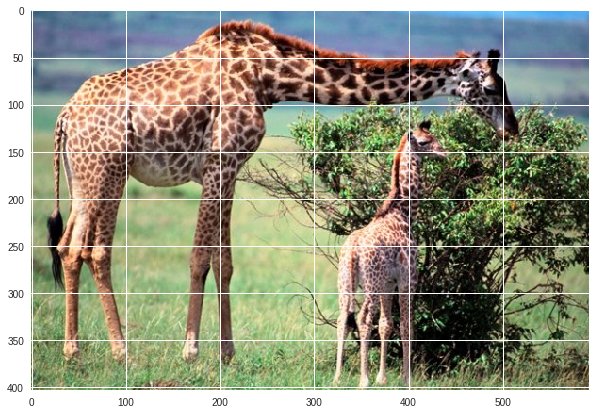

In [42]:
image = cv2.imread('gdrive/My Drive/coco_ds/BR0101171FG0010.jpg')
dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))
THRESHOLD = 0.2

plt.figure(figsize=(10,10))

input_image = cv2.resize(image, (416, 416))
input_image = input_image / 255.
input_image = input_image[:,:,::-1]
input_image = np.expand_dims(input_image, 0)

netout = new_model.predict([input_image, dummy_array])

boxes = decode_netout(netout[0], 
                      obj_threshold=THRESHOLD,
                      nms_threshold=THRESHOLD,
                      anchors=ANCHORS, 
                      nb_class=CLASS)
            
image = draw_boxes(image, boxes, labels=LABELS)

plt.imshow(image[:,:,::-1]); plt.show()